# <center> MSc General Project Notes </center>
# <center> Detection of Conciousness Using EEG </center>
# <center> Kevin Machado Gamboa </center> 

This Notebook contains code-notes used for training and evaluating models for consciousness detection.

The notebook is devided into the next sections:

1. [Dataset and Annotations](#1.-Dataset-and-Annotations)
10. [References](#10.-References)

### Libraries Needed

In [1]:
import os
import numpy as np
import random as rd
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# ML library
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

# Personal Libraries
os.chdir('../')
import utils
import config
import modelhub as mh
import databases as dbs
import functions_main as fm

## 1. Dataset and Annotations

The dataset used is from **Physionet** and anyone can access it as long as they conform to the terms of the specified [license](https://physionet.org/content/sleep-edfx/view-license/1.0.0/). This dataset contains 197 whole-night PolySomnoGraphic sleep recordings, including EEG and event markers among other physiological data. For more information visit [Physionet Sleep-EDF Database Expanded](https://physionet.org/content/sleep-edfx/1.0.0/).

For this notebook just the [Sleep Cassette Study and Data](https://physionet.org/content/sleep-edfx/1.0.0/) is been used. This database contains 153 files obtained from Caucasians aged 25-101, without any sleep-related medication [Ref 1].
As mentioned in the [Sleep Cassette Study](https://physionet.org/content/sleep-edfx/1.0.0/), "Two PSGs of about 20 hours each were recorded during two subsequent day-night periods at the subjects homes. Subjects continued their normal activities but wore a modified Walkman-like cassette-tape recorder described in chapter VI.4 (page 92) of Bob’s 1987 thesis [7]"
For more information on the dataset check [Ref 1].

All EEG signals were sampled at 100 Hz, and the event marker at 1 Hz.

The dataset can be imported using `mne` or can be downloaded locally. In this notebook we can use `databases.py` to import the data.

### 1.1 Loading raw data

The module `databases` allow us to load the sleep database in two main different ways:  **raw data** and **epochs and labels**.


For loading a list of raw data, we need to initialize the dataset with the number of files we would like to import (`t_files`) and the percentage of the data for testing `n_test`. Then we can use the `load_raw_data` method:

In [2]:
# initialize anaesthesia database
sleep = dbs.sleep()
# loading raw data
sleep.load_raw_data(t_files=5)
# info data loaded

Using default location ~/mne_data for PHYSIONET_SLEEP...


  0%|          | 0/5 [00:00<?, ?it/s]

Extracting EDF parameters from C:\Users\kevin\mne_data\physionet-sleep-data\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\kevin\mne_data\physionet-sleep-data\SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 40%|████      | 2/5 [00:00<00:00, 11.83it/s]

Extracting EDF parameters from C:\Users\kevin\mne_data\physionet-sleep-data\SC4021E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\kevin\mne_data\physionet-sleep-data\SC4031E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


 80%|████████  | 4/5 [00:00<00:00, 11.10it/s]

Extracting EDF parameters from C:\Users\kevin\mne_data\physionet-sleep-data\SC4041E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


100%|██████████| 5/5 [00:00<00:00, 11.29it/s]


With the `.info`method we can get some information of the loaded dataset.

In [3]:
print(sleep.info)

{'n_samples': 15384005, 'eeg_time': 153840.0}


We can also plot some of the loaded files as follow:

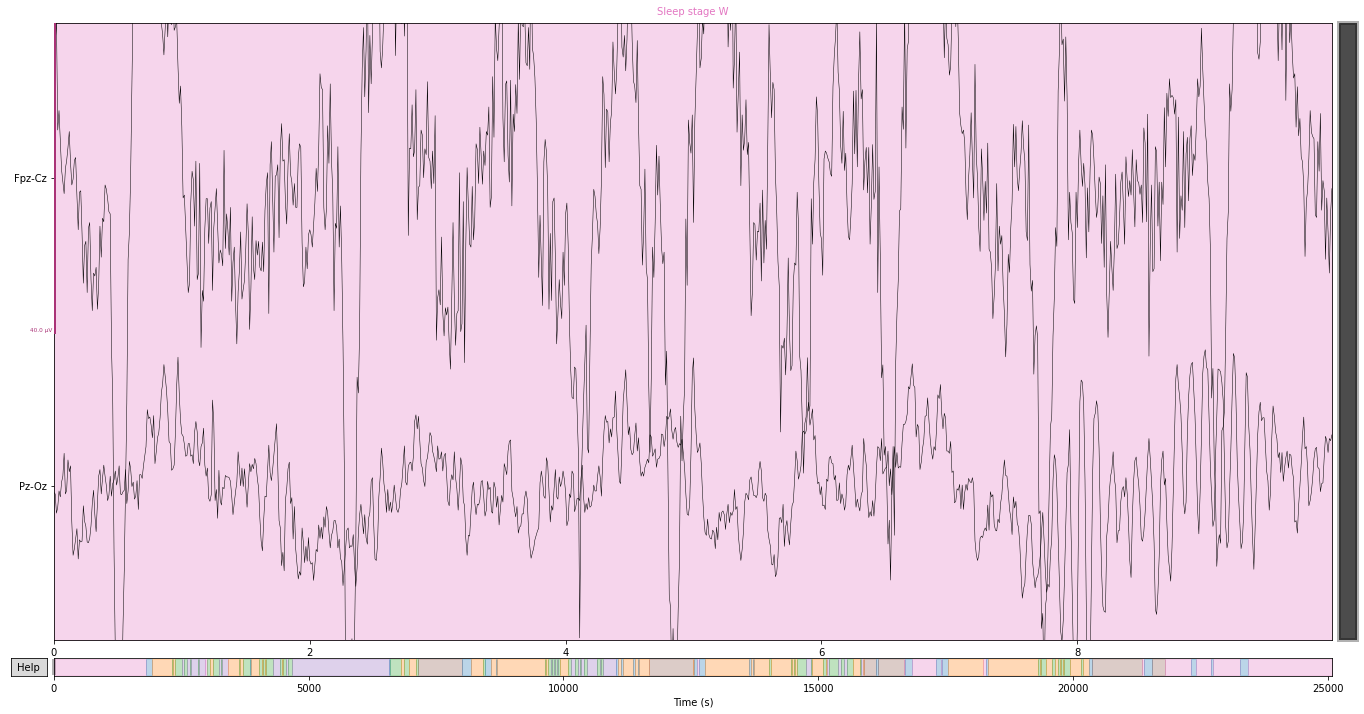

In [4]:
x = sleep.data[0]
plot = x.plot()

### 1.2 Loading epochs and labels

Apart from loading raw data files, we can import directly the epochs and labels to start training our model.

In [5]:
# initialize sleep database
sleep = dbs.sleep()
# loads [x_epochs, y_labels]
sleep.load_epochs_labels(t_files=5, n_test=0.30)

Using default location ~/mne_data for PHYSIONET_SLEEP...


  0%|          | 0/5 [00:00<?, ?it/s]

Extracting EDF parameters from C:\Users\kevin\mne_data\physionet-sleep-data\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2508000  =      0.000 ... 25080.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 49.50 Hz)
- Filter length: 331 samples (3.310 sec)

Used Annotations descriptions: ['Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage W']
Not setting metadata
Not setting metadata
6530 matching events found
No baseline correction applied
0

 20%|██        | 1/5 [00:02<00:10,  2.51s/it]

Extracting EDF parameters from C:\Users\kevin\mne_data\physionet-sleep-data\SC4011E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3261000  =      0.000 ... 32610.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 49.50 Hz)
- Filter length: 331 samples (3.310 sec)

Used Annotations descriptions: ['Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage W']
Not setting metadata
Not setting metadata
8080 matching events found
No baseline correction applied
0

 40%|████      | 2/5 [00:05<00:08,  2.67s/it]

Extracting EDF parameters from C:\Users\kevin\mne_data\physionet-sleep-data\SC4021E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3060000  =      0.000 ... 30600.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 49.50 Hz)
- Filter length: 331 samples (3.310 sec)

Used Annotations descriptions: ['Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage W']
Not setting metadata
Not setting metadata
7630 matching events found
No baseline correction applied
0

 60%|██████    | 3/5 [00:07<00:05,  2.60s/it]

Extracting EDF parameters from C:\Users\kevin\mne_data\physionet-sleep-data\SC4031E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2850000  =      0.000 ... 28500.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 49.50 Hz)
- Filter length: 331 samples (3.310 sec)

Used Annotations descriptions: ['Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage W']
Not setting metadata
Not setting metadata
6800 matching events found
No baseline correction applied
0

 80%|████████  | 4/5 [00:09<00:02,  2.44s/it]

Extracting EDF parameters from C:\Users\kevin\mne_data\physionet-sleep-data\SC4041E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3705000  =      0.000 ... 37050.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 49.50 Hz)
- Filter length: 331 samples (3.310 sec)

Used Annotations descriptions: ['Sleep stage 2', 'Sleep stage 3', 'Sleep stage W']
Not setting metadata
Not setting metadata
8720 matching events found
No baseline correction applied
0 projection items

100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


Originally, the categories for this dataset are 5, including Awake, and 4 sleep stages. We can binarize this to obtain the classes consciousness and unconsciousness as follow:

In [6]:
sleep.get_binary_labels()

sleep dataset with binary labels: [0=>conscious, 1=>unconscious]


We can visualize some of the epochs using `show_samples` from the module `utils`.

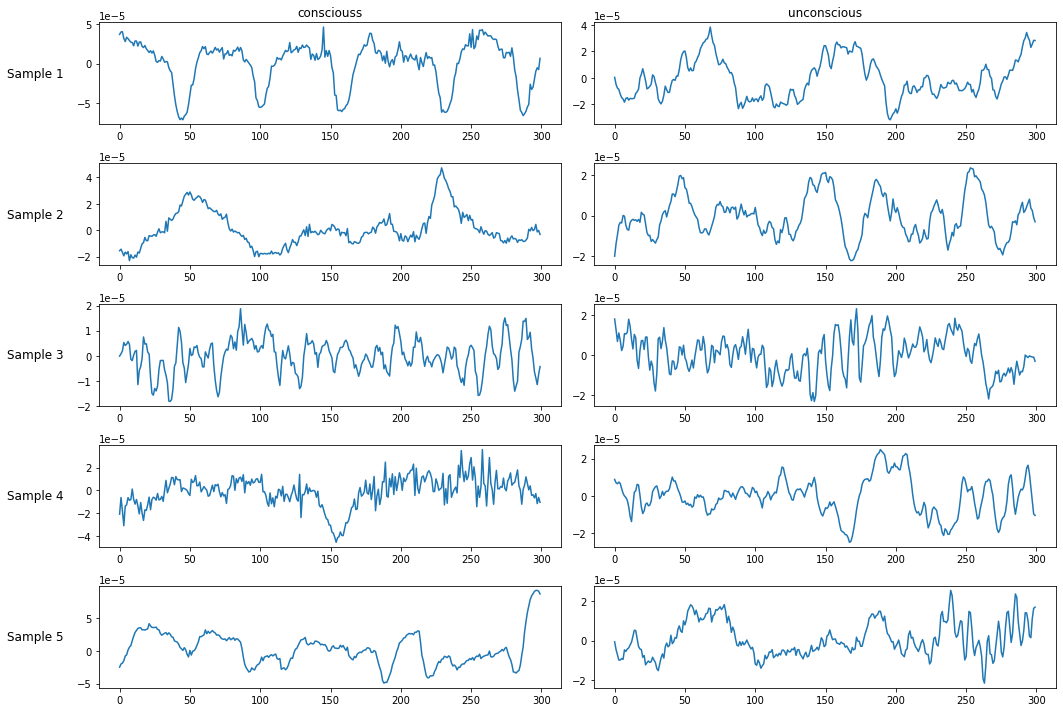

In [7]:
utils.show_samples(sleep.data['train'], {0: 'consciouss', 1: 'unconscious'})

Given that the amplitud of these eeg signals is to small and varies accross epochs, we can also apply a normalization process using the `transform` method to have all epochs ranging from [-1, 1]

In [8]:
sleep.transform(fm.nor_dataset)

  2%|▏         | 433/26432 [00:00<00:06, 4329.69it/s]

transforming training dataset


  7%|▋         | 846/11328 [00:00<00:02, 4236.70it/s]

transforming test dataset


100%|██████████| 11328/11328 [00:02<00:00, 4259.90it/s]


In [ ]:
utils.show_samples(sleep.data['train'], {0: 'consciouss', 1: 'unconscious'})

### 1.3 Applying Transformations to Dataset

Using the `transform` method we can apply any transformation to our epochs dataset. In the next example we will applyed the signal spectrogram from `fm.raw_chunks_to_spectrograms`

In [ ]:
sleep.transform(fm.raw_chunks_to_spectrograms, name='spectrogram')

In [ ]:
imshow_samples(sleep.data['train'], {0: 'consciouss', 1: 'unconscious'})

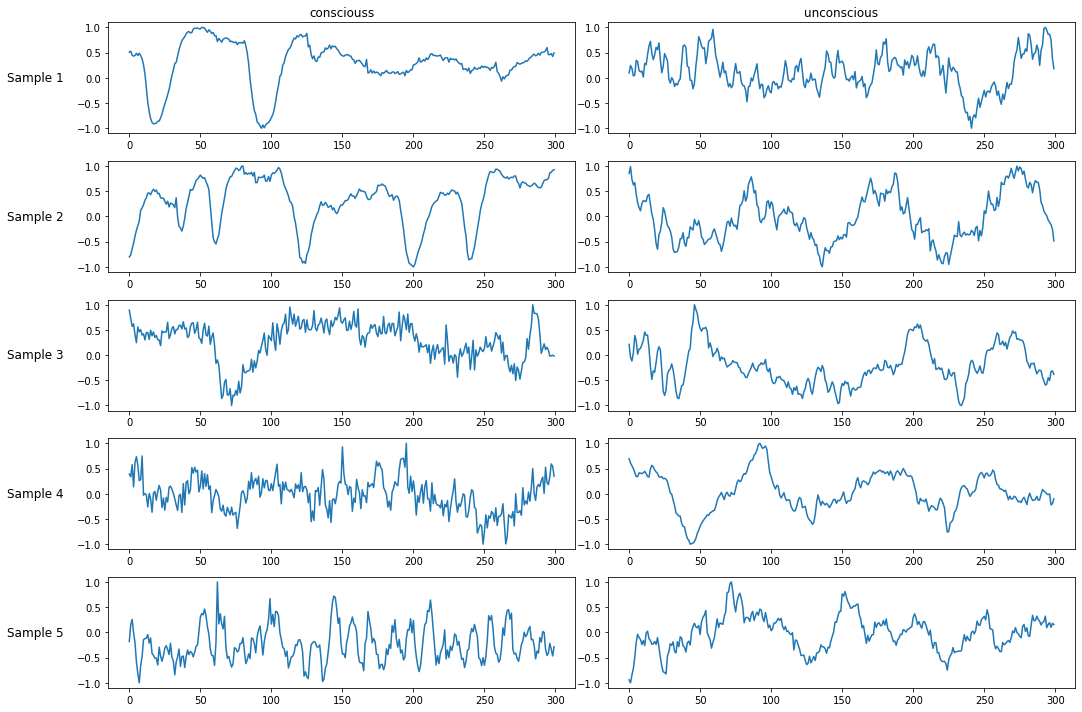

In [9]:
## 2. References

[1] B Kemp, AH Zwinderman, B Tuk, HAC Kamphuisen, JJL Oberyé. Analysis of a sleep-dependent neuronal feedback loop: the slow-wave microcontinuity of the EEG. IEEE-BME 47(9):1185-1194 (2000).


### 1.3 Applying Transformations to Dataset

Using the `transform` method we can apply any transformation to our epochs dataset. In the next example we will applyed the signal spectrogram from `fm.raw_chunks_to_spectrograms`

In [10]:
sleep.transform(fm.raw_chunks_to_spectrograms, name='spectrogram')

  0%|          | 0/26432 [00:00<?, ?it/s]D:\Folder\Repositories\consciousness\functions_main.py:413: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = np.vstack(signal[i:i + number_time_samples] for i in range(0, len(signal) - number_time_samples, stepsize))
  0%|          | 51/26432 [00:00<00:51, 509.96it/s]

transforming training dataset
applying spectrogram transformation


  0%|          | 50/11328 [00:00<00:22, 499.95it/s]

Finished spectrogram transformation
transforming test dataset
applying spectrogram transformation


100%|██████████| 11328/11328 [00:25<00:00, 437.73it/s]

Finished spectrogram transformation


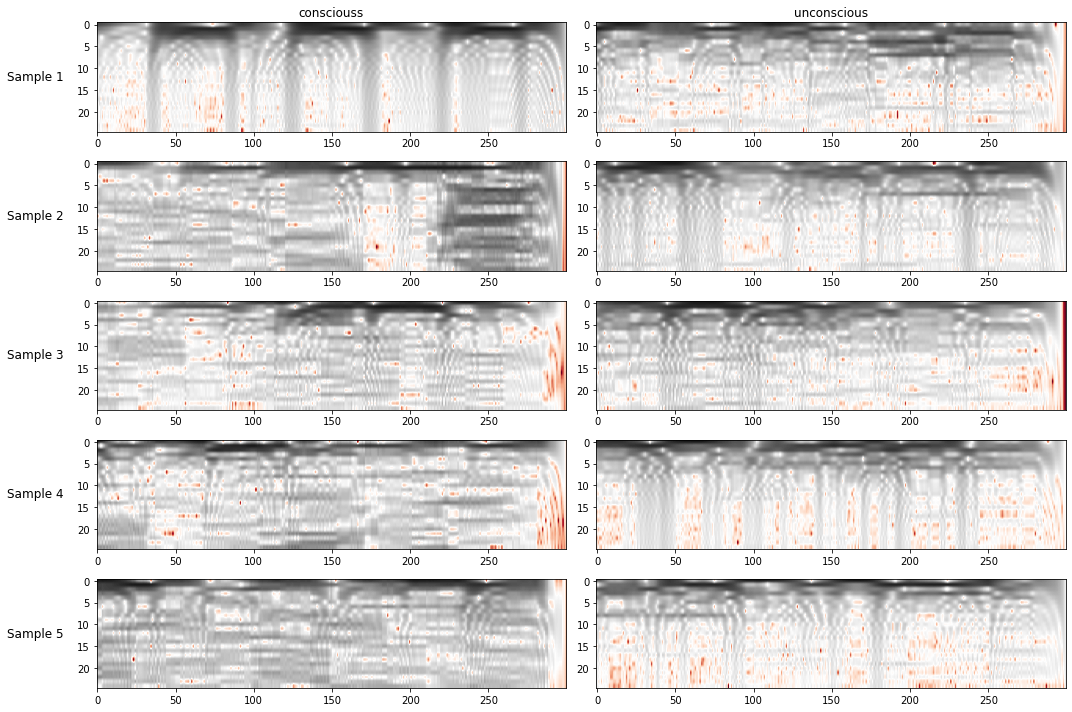

In [14]:
imshow_samples(sleep.data['train'], {0: 'consciouss', 1: 'unconscious'})

## 2. References

[1] B Kemp, AH Zwinderman, B Tuk, HAC Kamphuisen, JJL Oberyé. Analysis of a sleep-dependent neuronal feedback loop: the slow-wave microcontinuity of the EEG. IEEE-BME 47(9):1185-1194 (2000).
